In [180]:
import json
import re

In [181]:
descriptions = {}

with open("./../data/races/races-description.jl") as f:
    for line in f.readlines():
        data = json.loads(line.strip())
        if (data.get('id', "TBD") != "TBD"):
            descriptions[data['id']] = data
        else:
            descriptions[f"TBD_{data['name']}"] = data

In [182]:
len(descriptions)

223

In [507]:
re.search("!function", descriptions['italy70.3']['description'])

<re.Match object; span=(577, 586), match='!function'>

# Tokenization

In [183]:
import string
import spacy
import gensim

# Initialize spacy's model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

In [598]:
customize_stop_words = [
    "Race", "Races", "race", "info", "about", "finish", "line", 
    "swim", "bike", "run", 'athlete', 'ironman', "d'aix", "aix",
    "triathlete", "course", '-', 'km', 'list', 'athletes', 'click', 'en', 'category', 
    'event', 'video', 'host', 'country', 'find', 'app', 'store', 'android', 'phone', 'search',
    'offer', 'slot', 'loop', 'mile', 'time', 'transition', 'qualify', 'award', 'th', 'www', 'xi',
    'taupō', 'qualifying', 'winner', 'choice', 'triclub', 'triathlon', 'taupõ', 'lap', 'distance',
    'return', 'point', 'type', 'ride', 'long', 'age', 'group', 'fbq', 'year', 'destination', 'town',
    'tri', 'tr', 'nth', 'vote', 'watch'
]

# add name of race as stop words
for race in descriptions:
    authorized_words = ['island', 'pacific']
    name = descriptions[race]['name']
    customize_stop_words.extend([token.lemma_.lower() for token in nlp(name) if token.lemma_.lower() not in [authorized_words]])

customize_stop_words = set(customize_stop_words)

for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [599]:
punctuations = string.punctuation

class DescriptionTokenizer:
    def __init__(self, text):
        self.description = text
        # preprocess text
        to_process = self.preprocess(text)
        self.tokenized = self.tokenize(nlp(to_process))
        
    @staticmethod
    def preprocess(text):
        """Remove the js code at end of some descriptions and preprocess with gensim"""
        isMatch = re.search("(Read More)", text)
        if isMatch:
            idx = int(isMatch.start())
            text = text[0:idx]
        isMatch = re.search("!function", text)
        if isMatch:
            idx = int(isMatch.start())
            text = text[0:idx]
        return ' '.join(gensim.utils.simple_preprocess(text))
    
    @staticmethod
    def extended_is_stop(token):
        stop_words = nlp.Defaults.stop_words
        return token.is_stop or token.lower_ in stop_words or token.lemma_ in stop_words or re.match("\d+", token.text)
    
    @staticmethod
    def lemmatize(tokens):
        # Lemmatizing each token and converting each token into lowercase
        return [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
    
    def remove_stop_words(self, tokens):
        return [word for word in tokens 
                    if not self.extended_is_stop(word) 
                    and word.lower_ not in punctuations ]
        
    def tokenize(self, doc):
        tokens = self.remove_stop_words(doc)
        tokens = self.lemmatize(tokens)
#         # second pass
#         tokens = self.remove_stop_words(nlp(" ".join(tokens)))
#         tokens = self.lemmatize(tokens)
        return [token for token in tokens if token not in customize_stop_words]

In [600]:
descriptions_lemma = {}

for key in descriptions:
    text = descriptions[key].get('description')
    processed = DescriptionTokenizer(text).tokenized
    if 'discontinue' not in processed:
        descriptions_lemma[key] = processed

len(descriptions_lemma)

167

In [601]:
# descriptions_lemma

In [602]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.parsing.preprocessing import preprocess_string
from sklearn import utils
from sklearn import metrics
from tqdm import tqdm
import multiprocessing
import numpy as np
import umap

class Doc2VecTransformer(BaseEstimator):
    def __init__(self, vector_size=10, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count()

    def fit(self, docs, df_y=None):
        tagged_x = [TaggedDocument(doc, [index]) for index, doc in enumerate(docs)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers, min_count=3)
        for epoch in range(self.epochs):
            model.train(utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha
            self._model = model
        return self

    def transform(self, docs):
        return np.asmatrix(np.array([self._model.infer_vector(doc) for doc in docs]))

In [603]:
keys = descriptions_lemma.keys()
docs = descriptions_lemma.values()

regions = [descriptions[key]['region'] for key in keys]
colors_hash = {region: i for i,region in enumerate(np.unique(regions))}

# embed descriptions into vectors
model = Doc2VecTransformer(vector_size=10)
model.fit(docs)
res = model.transform(docs)

# run PCA
pca = PCA(n_components=10)
pca.fit(res)
out = pca.transform(res)

100%|██████████| 167/167 [00:00<00:00, 450159.88it/s]


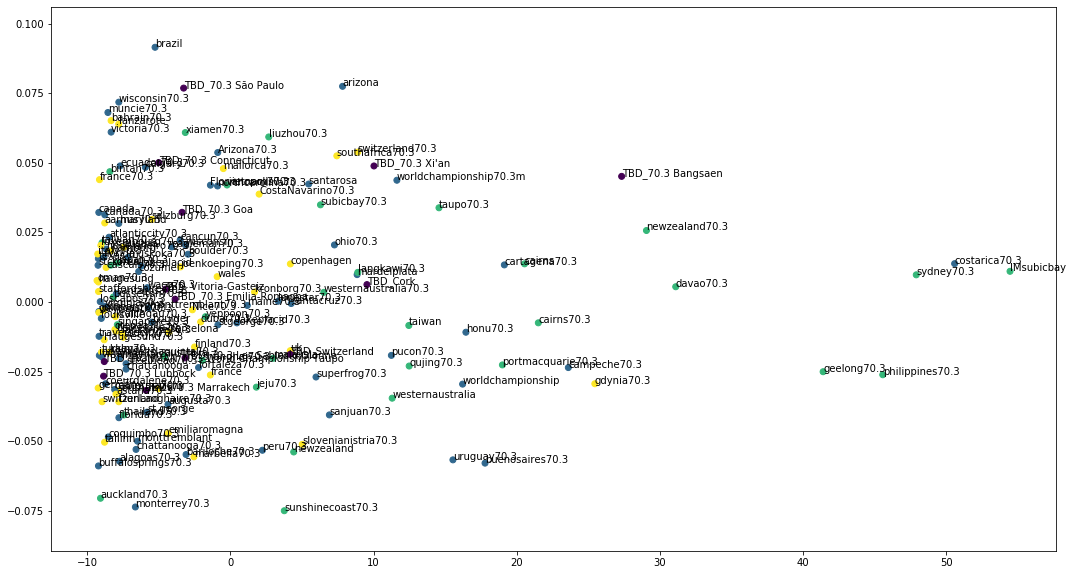

In [604]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(18, 10))

ax.scatter(out[:, 0], out[:, 1], c=[colors_hash[region] for region in regions])

for i, txt in enumerate(descriptions_lemma):
    ax.annotate(txt, (out[i, 0], out[i, 1]))

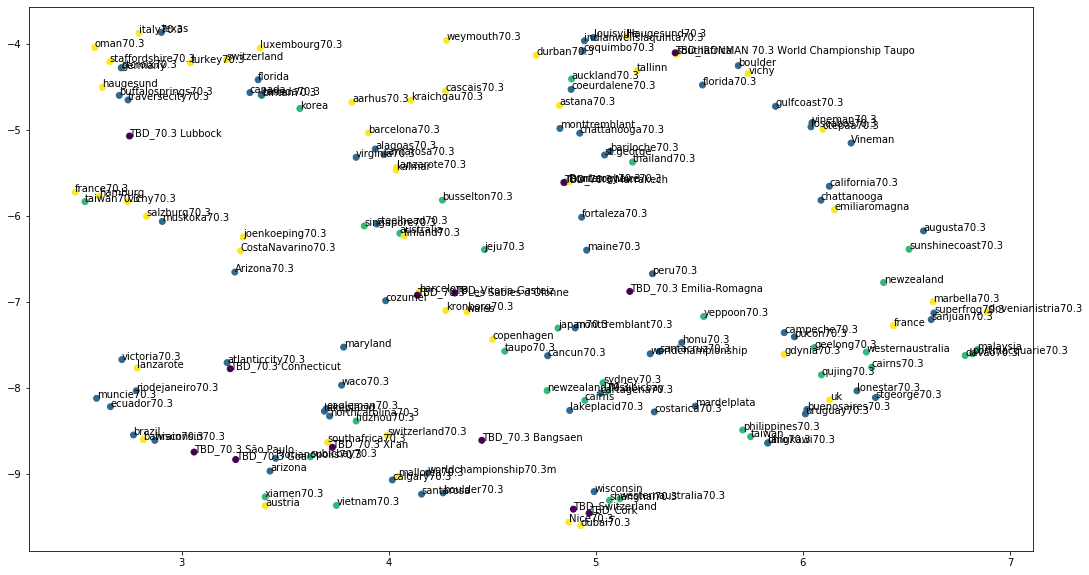

In [639]:
# run UMAP
umap_model = umap.UMAP(n_neighbors=5,
                       min_dist=0.01,
                       metric='cosine')
umap_embedding = umap_model.fit_transform(res)


fig,ax = plt.subplots(figsize=(18, 10))

ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=[colors_hash[region] for region in regions])

for i, txt in enumerate(descriptions_lemma):
    ax.annotate(txt, (umap_embedding[i, 0], umap_embedding[i, 1]))

# Doc2Vec

In [606]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [607]:
taggedDocs = []
for race in descriptions_lemma:
    description = descriptions_lemma[race]
    taggedDocs.append(gensim.models.doc2vec.TaggedDocument(description, [race]))


### Training the Model

Instantiate a Doc2Vec Object

Now, we'll instantiate a Doc2Vec model with a vector size with 50 words and iterating over the training corpus 40 times. We set the minimum word count to 2 in order to discard words with very few occurrences. (Without a variety of representative examples, retaining such infrequent words can often make a model worse!) Typical iteration counts in published 'Paragraph Vectors' results, using 10s-of-thousands to millions of docs, are 10-20. More iterations take more time and eventually reach a point of diminishing returns.

However, this is a very very small dataset (223 documents) with shortish documents (a few hundred words). Adding training passes can sometimes help with such small datasets.

In [608]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=20, min_count=2, epochs=100)

### build vocabulary
Essentially, the vocabulary is a dictionary (accessible via model.wv.vocab) of all of the unique words extracted from the training corpus along with the count (e.g., model.wv.vocab['penalty'].count for counts for the word penalty).

In [609]:
train_corpus = taggedDocs
model.build_vocab(train_corpus)

In [610]:
# sorted([(word, model.wv.vocab[word].count) for word in model.wv.vocab], key=lambda x: x[1], reverse=True)

### Time to Train

If the BLAS library is being used, this should take no more than 3 seconds. If the BLAS library is not being used, this should take no more than 2 minutes, so use BLAS if you value your time.

In [611]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 1.87 s, sys: 75.1 ms, total: 1.95 s
Wall time: 1.41 s


### Assessing Model

To assess our new model, we'll first infer new vectors for each document of the training corpus, compare the inferred vectors with the training corpus, and then returning the rank of the document based on self-similarity. Basically, we're pretending as if the training corpus is some new unseen data and then seeing how they compare with the trained model. The expectation is that we've likely overfit our model (i.e., all of the ranks will be less than 2) and so we should be able to find similar documents very easily. Additionally, we'll keep track of the second ranks for a comparison of less similar documents.

In [612]:
ranks = []
second_ranks = []
for i,doc_id in enumerate(descriptions_lemma):
    inferred_vector = model.infer_vector(train_corpus[i].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    
    second_ranks.append(sims[1])

In [613]:
# collections.Counter(ranks)

In [669]:
query_tokens = ["vacation", "family", "activity", "beach", "fast"]
tokens_input = DescriptionTokenizer(" ".join(query_tokens)).tokenized

inferred_vector = model.infer_vector(tokens_input, steps=20)
model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))[:10]

[('marbella70.3', 0.7233032584190369),
 ('steelhead70.3', 0.7025799751281738),
 ('bahrain70.3', 0.6690818071365356),
 ('santarosa70.3', 0.6530136466026306),
 ('austria', 0.6412849426269531),
 ('westernaustralia70.3', 0.6297218203544617),
 ('taiwan70.3', 0.6218444108963013),
 ('singapore70.3', 0.6160390377044678),
 ('westernaustralia', 0.6081892848014832),
 ('otepaa70.3', 0.6060105562210083)]

In [665]:
tokens_input

['vacation', 'family', 'activity']

In [626]:
descriptions_lemma['fortaleza70.3']

['unique',
 'coastal',
 'landscape',
 'beach',
 'relax',
 'atmosphere',
 'fantastic',
 'family',
 'popular',
 'domestic',
 'tourist',
 'quickly',
 'worldwide',
 'vacation',
 'stop',
 'renowne',
 'local',
 'cuisine',
 'epic',
 'sunset',
 'visitor',
 'chance',
 'visit',
 'historic',
 'landmark',
 'include',
 'jose',
 'alencar',
 'theater',
 'dragao',
 'mar',
 'cultural',
 'center',
 'variety',
 'museum',
 'cathedral',
 'family',
 'explore',
 'spectacular',
 'beach',
 'park',
 'large',
 'water',
 'park',
 'latin',
 'america',
 'ecological',
 'park',
 'include',
 'botanico',
 'park',
 'coco',
 'ipark',
 'sun',
 'beach',
 'isn',
 'surfing',
 'snorkeling',
 'popular',
 'water',
 'activity',
 'fan',
 'enjoy',
 'warm',
 'kona',
 'like',
 'temperature',
 'humidity',
 'day',
 'begin',
 'start',
 'golden',
 'sand',
 'iracema',
 'beach',
 'follow',
 'single',
 'begin',
 'iracema',
 'beach',
 'extend',
 'ce',
 'road',
 'follow',
 'palm',
 'tree',
 'street',
 'breathtake',
 'seaside',
 'view',
 'way

In [624]:
inferred_vector = model.infer_vector(descriptions_lemma['boulder'])
model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))[:10]

[('boulder', 0.9041417837142944),
 ('lakeplacid', 0.779284656047821),
 ('lakeplacid70.3', 0.7579605579376221),
 ('gulfcoast70.3', 0.7387644648551941),
 ('chattanooga', 0.7200878858566284),
 ('ohio70.3', 0.6896880865097046),
 ('chattanooga70.3', 0.6705812215805054),
 ('oman70.3', 0.6689744591712952),
 ('indianwellslaquinta70.3', 0.6633546948432922),
 ('boulder70.3', 0.6581496000289917)]